In [1]:
## ---------------------------------------------------------
## Import libraries
## ---------------------------------------------------------

import numpy as np
import pandas as pd
from pandas import DataFrame
from patsy import dmatrices, dmatrix
from sklearn.preprocessing import StandardScaler
import theano
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pymc3 as pm
from scipy import stats

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
## ---------------------------------------------------------
## Preprocessing
## ---------------------------------------------------------

# training data
df_train = pd.read_csv('DILI_raw_data.txt', delim_whitespace=True)

# select predictors
drug_names = df_train[['Drug']]
df_train = df_train[['Spher','BSEP', 'THP1', 'Glu', 'Glu.Gal', 'ClogP', 'log10.cmax', 'BA', 'dili.sev']]

# rename columns
df_train = df_train.rename(columns={'dili.sev': 'y', 'log10.cmax':'log10cmax', 'Glu.Gal': 'Glu_Gal'})

# test data
test_dat = {'AZID':  ['AZD123', 'AZD456'],
       'Spher':    [250, 250],
       'BSEP':     [314, 1000],
       'THP1':     [250, 250],
       'Glu':      [250, 250],
       'Glu_Gal':  [1, 1],
       'ClogP':    [2.501, 3.900],
       'BA':  [0, 0],
       'log10cmax':  [0.5051500, 0.7075702]
        }
df_test = DataFrame (test_dat)

# select variables for scaling
X_train = df_train[['Spher','BSEP', 'THP1', 'Glu', 'Glu_Gal', 'ClogP', 'log10cmax']]
X_test   = df_test[['Spher','BSEP', 'THP1', 'Glu', 'Glu_Gal', 'ClogP', 'log10cmax']]

# standardize train and test data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

df_Xtrain = pd.DataFrame(X_train)
df_Xtest = pd.DataFrame(X_test)

# return Bioactivation (it did not require standardisation)
df_Xtrain['BA'] = df_train['BA']
df_Xtest['BA'] = df_test['BA']

df_Xtrain.columns = ['Spher','BSEP', 'THP1', 'Glu', 'Glu_Gal', 'ClogP', 'log10cmax', 'BA']
df_Xtest.columns = ['Spher','BSEP', 'THP1', 'Glu', 'Glu_Gal', 'ClogP', 'log10cmax', 'BA']

# design matrices
X_train = pd.DataFrame(dmatrix("0 + (Spher + BSEP + THP1 + Glu + Glu_Gal + ClogP + BA)**2 + log10cmax", df_Xtrain))
X_test = pd.DataFrame(dmatrix("0 + (Spher + BSEP + THP1 + Glu + Glu_Gal + ClogP + BA)**2 + log10cmax", df_Xtest))

y_train = df_train['y'].values

/Users/kcft114/anaconda3/envs/pymc_env/lib/python3.5/site-packages/ipykernel_launcher.py:35: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


In [3]:
## ---------------------------------------------------------
## Define and fit model
## ---------------------------------------------------------

N = X_train.shape[0]
p = X_train.shape[1]
X_train = X_train.values
#y_train.reshape((96,1));
sigma_prior = 1

# share variable to enable predictions
X_shared = theano.shared(X_train)
y_shared = theano.shared(y_train)

with pm.Model() as model:
    
    mu_beta = pm.Normal('mu_beta', mu=0, sd=2)    
    sd_beta = pm.HalfNormal('sd', sd=sigma_prior)
    beta = pm.Laplace('beta', mu=mu_beta, b=sd_beta, shape=p)    
    
    cutpoints = pm.Normal("cutpoints", mu=[-0.001,0], sd=20, shape=2,
                           transform=pm.distributions.transforms.ordered)
    
    lp = pm.Deterministic('lp', pm.math.dot(X_shared, beta))

    y_obs = pm.OrderedLogistic("y_obs", eta=lp, cutpoints=cutpoints, observed=y_shared-1)
    
    trace = pm.sample(samples = 20000)

/Users/kcft114/anaconda3/envs/pymc_env/lib/python3.5/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/kcft114/anaconda3/envs/pymc_env/lib/python3.5/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/kcft114/anaconda3/envs/pymc_env/lib/python3.5/site-packages/theano/tensor/subtensor.py:

In [4]:
## ---------------------------------------------------------
## predict for training data
## ---------------------------------------------------------

post_pred_train = pm.sample_ppc(trace, samples=5000, model=model)

# exctract predictions
y_pred_train_df = post_pred_train['y_obs']

100%|██████████| 5000/5000 [01:18<00:00, 49.93it/s]


In [6]:
## ---------------------------------------------------------
## Helper functions
## ---------------------------------------------------------

def logistic(x):
    return 1 / (1 + np.exp(-x))

# posterior prediction for each category
def probs(y_pred_df, ind):
    y_pred_ind = y_pred_df[:,ind]
    p = [sum(y_pred_ind == 0)/len(y_pred_ind), sum(y_pred_ind == 1)/len(y_pred_ind), sum(y_pred_ind == 2)/len(y_pred_ind)]
    return p

# percent of distribution in each category (blue densities)
def percs(lp, ind):
    lp_ind = lp[:,ind]
    ps = [np.mean(lp_ind <= c1), np.mean((lp_ind > c1) * (lp_ind <= c2)), np.mean(lp_ind > c2)]
    return ps

def summary_stats(post_ind):
    #peak 
    post_ind_long = np.append(np.append(0., post_ind), 1.)
    dens_vals = sns.kdeplot(post_ind_long, shade=True, bw=.005).get_lines()[0].get_data()[1]
    dens_x = sns.kdeplot(post_ind_long, shade=True, bw=.005).get_lines()[0].get_data()[0]
    post_peak = round(dens_x[np.argmax(dens_vals)],2)
    
    post_mean = round(np.mean(post_ind),2)
    post_median = round(np.median(post_ind),2)
    post_q025 = round(np.quantile(post_ind, 0.025),2)
    post_q975 = round(np.quantile(post_ind, 0.975),2)
    
    plt.close()
    
    return post_peak, post_mean, post_median, post_q025, post_q975

In [7]:
## ---------------------------------------------------------
## Plot results
## ---------------------------------------------------------

## extract predicted values and convert to 0-1 scale
lp = trace['lp']
post = logistic(lp)

# exctract cutpoints
cutpoints = trace['cutpoints']
c1 = np.mean(logistic(cutpoints[:,0]))
c2 = np.mean(logistic(cutpoints[:,1]))

In [8]:
# calculate average profile for DILI category 3 compounds

y_3 = np.array(np.where(y_train == 3))[0]

av3 = np.zeros((128, len(y_3)))

counter = 0
for ind in y_3:
    post_ind = post[:,ind]
    post_ind_long = np.append(np.append(0., post_ind), 1.)
    #dens_vals = sns.distplot(lp_ind).get_lines()[0].get_data()[1]
    dens_vals = sns.kdeplot(post_ind_long, shade=True, bw=.005).get_lines()[0].get_data()[1]
    av3[:,counter] = dens_vals
    counter = counter + 1
    plt.close()

av3_x = sns.kdeplot(post_ind_long, shade=True, bw=.005).get_lines()[0].get_data()[0]
av3_y = np.mean(av3, axis=1)
plt.close()

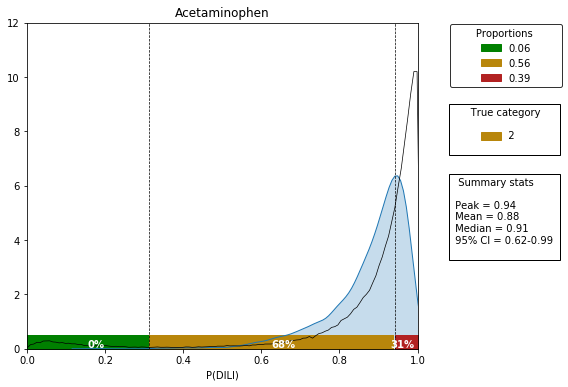

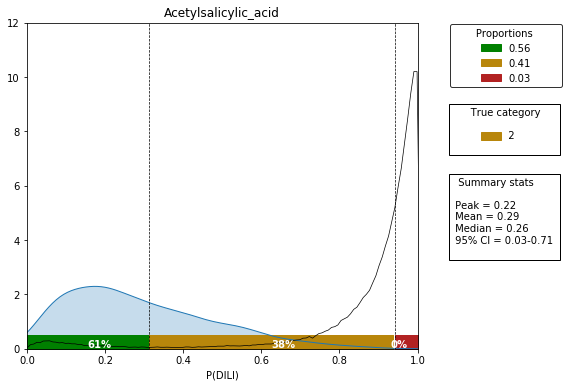

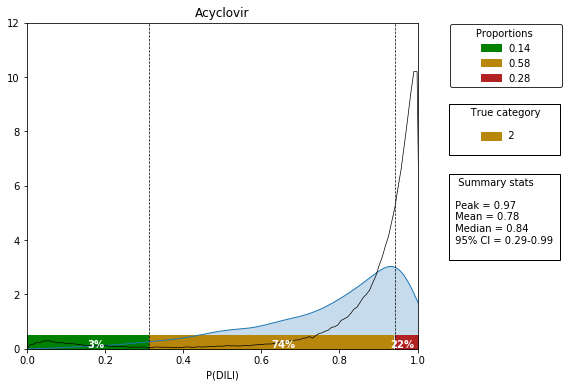

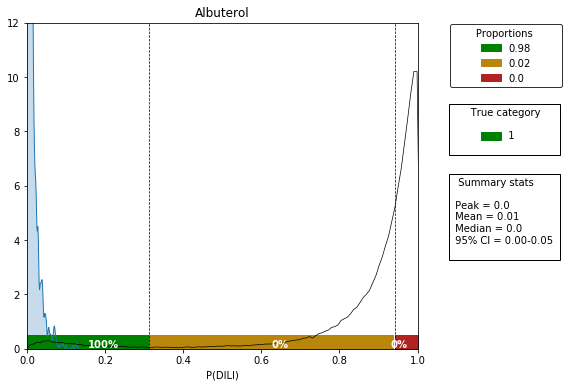

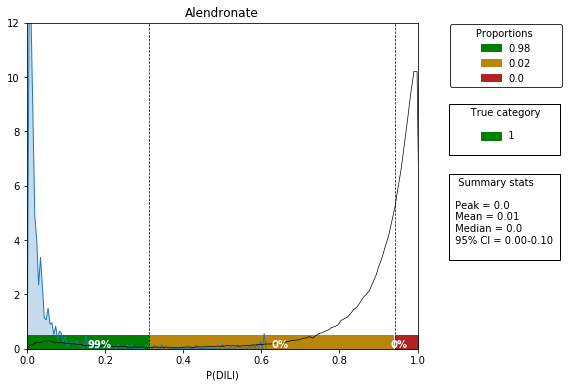

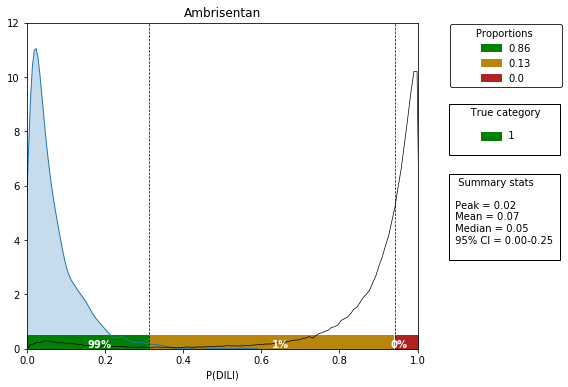

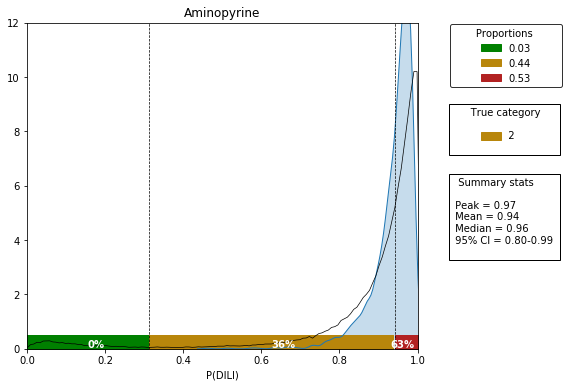

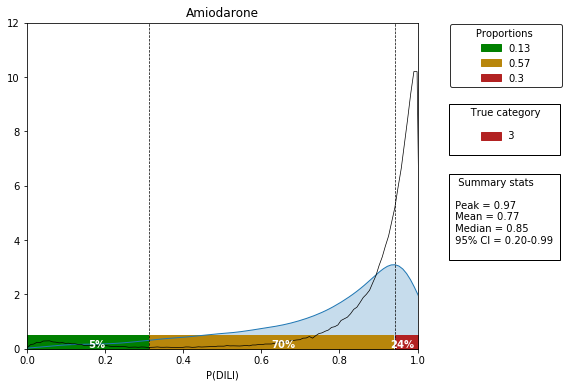

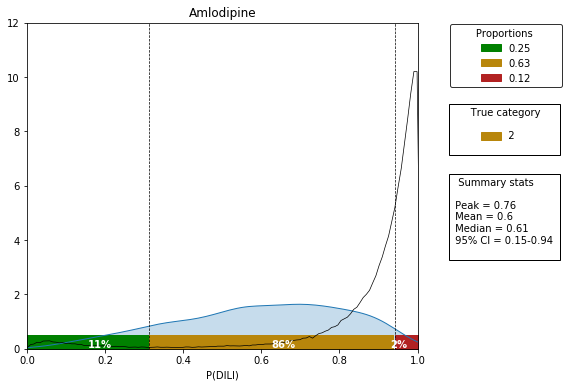

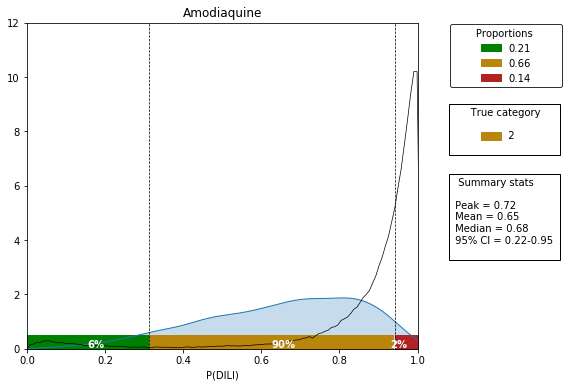

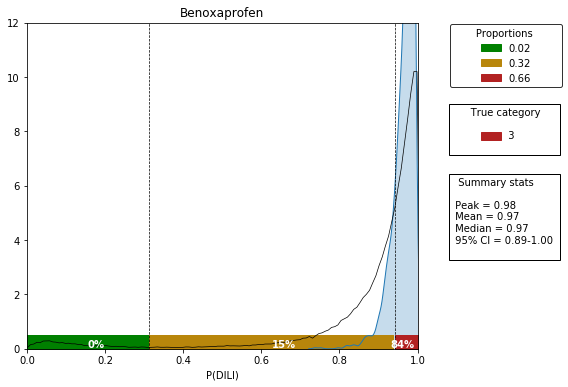

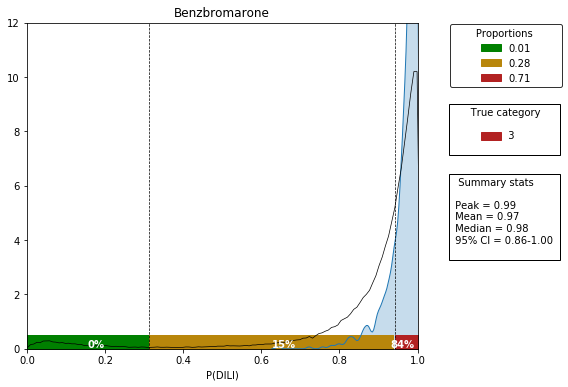

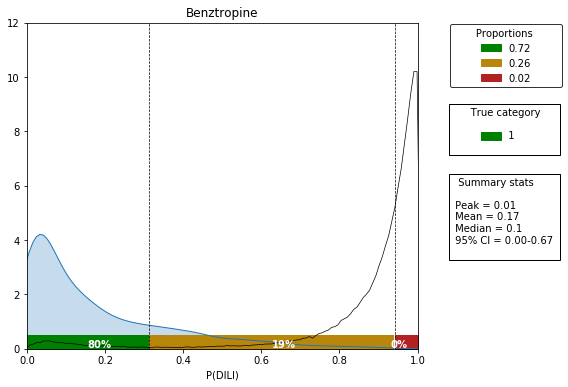

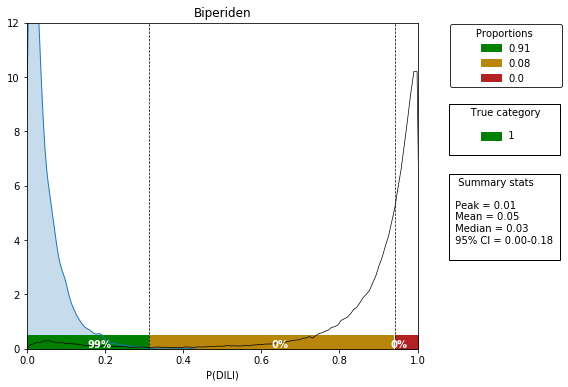

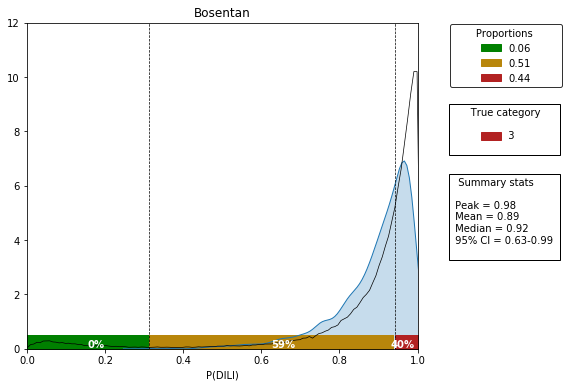

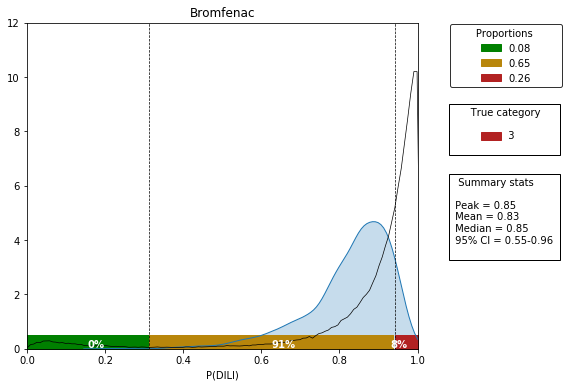

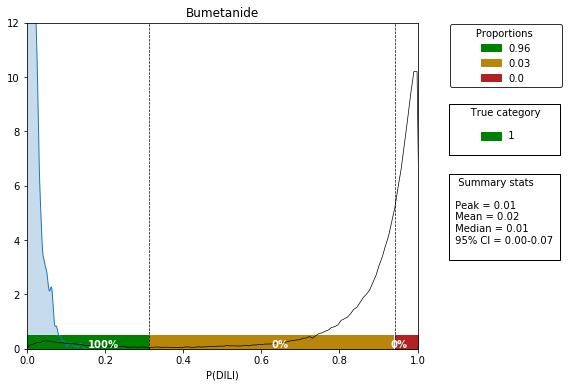

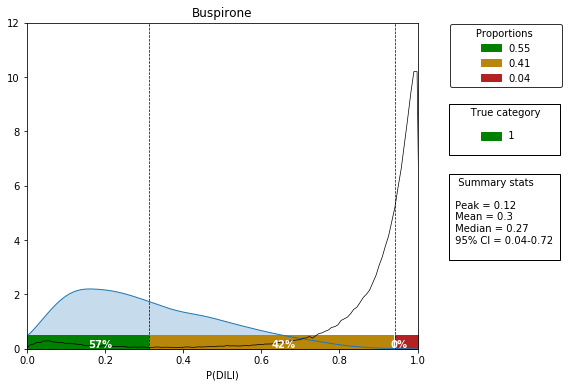

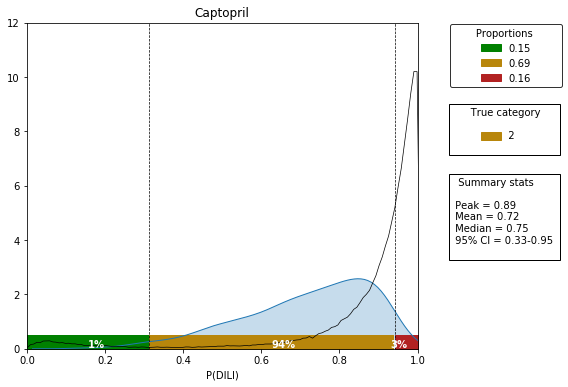

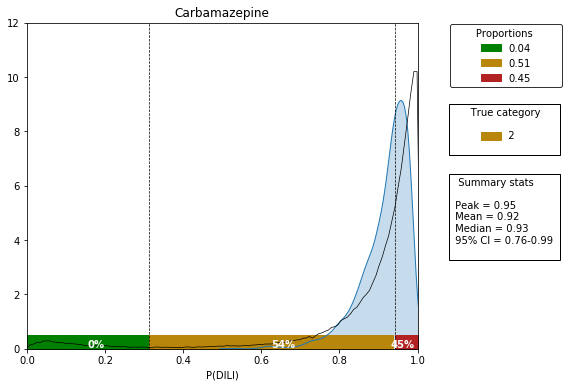

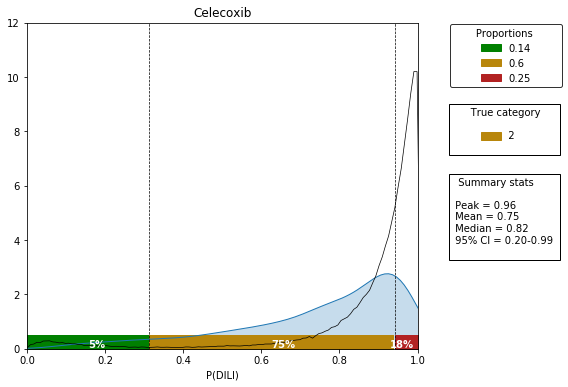

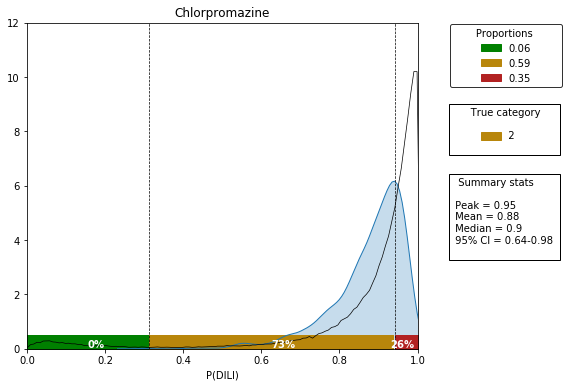

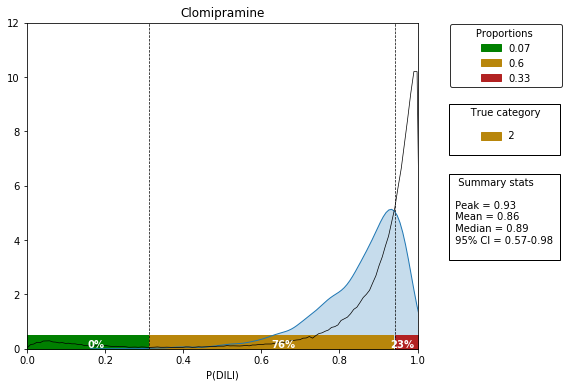

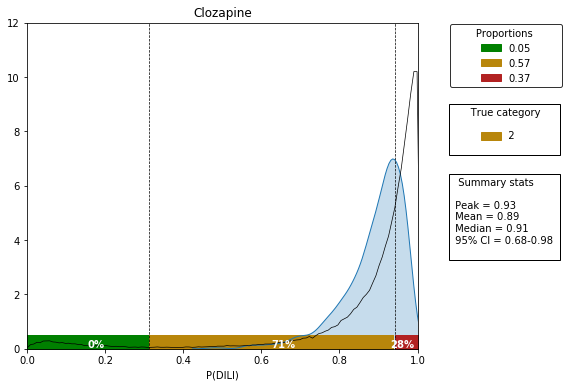

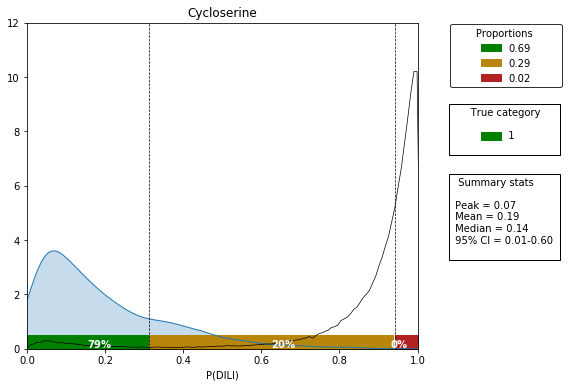

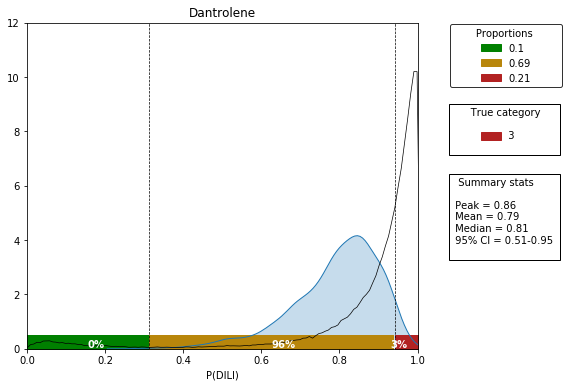

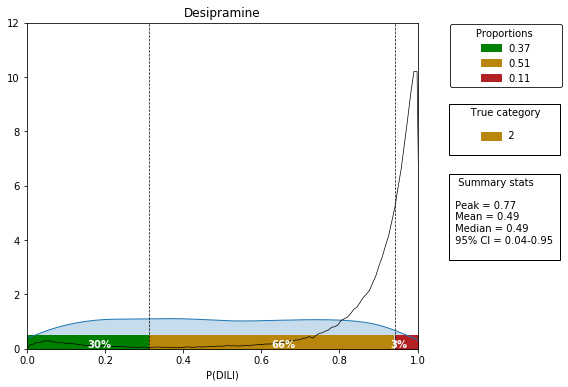

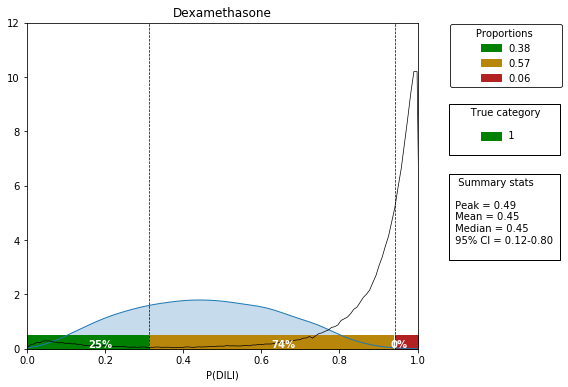

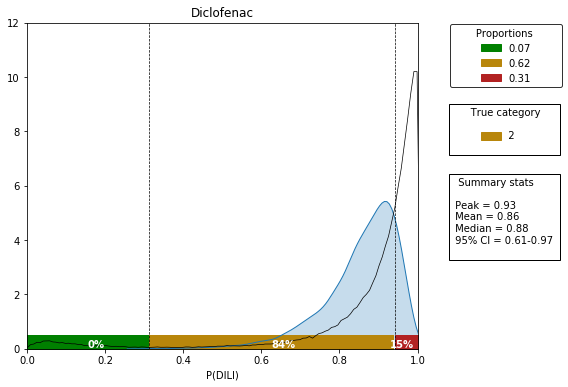

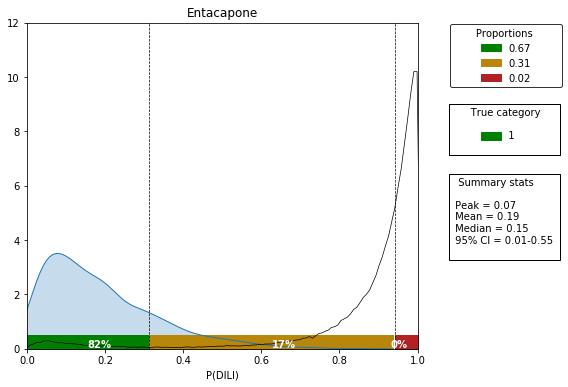

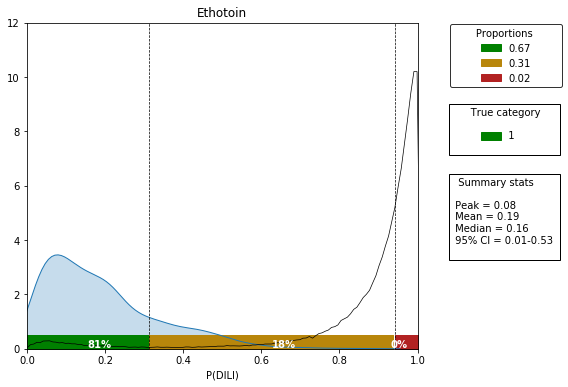

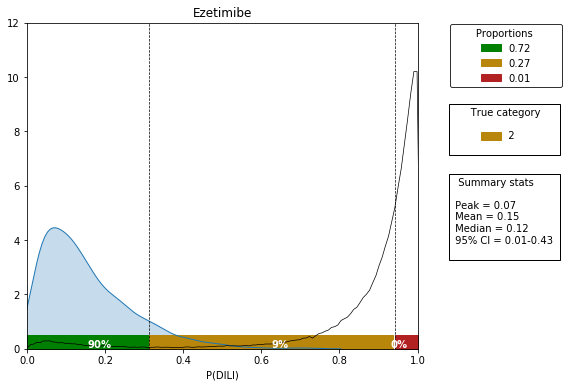

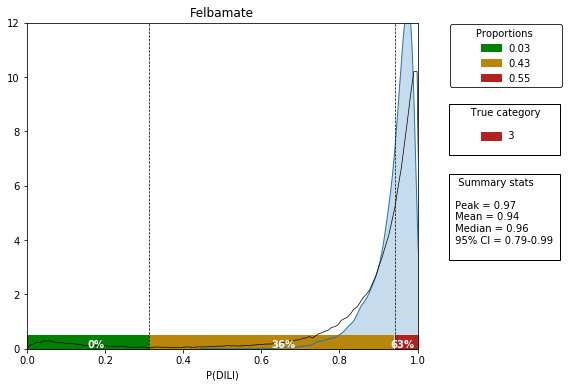

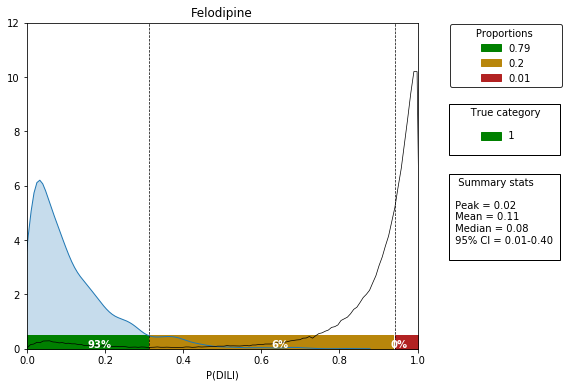

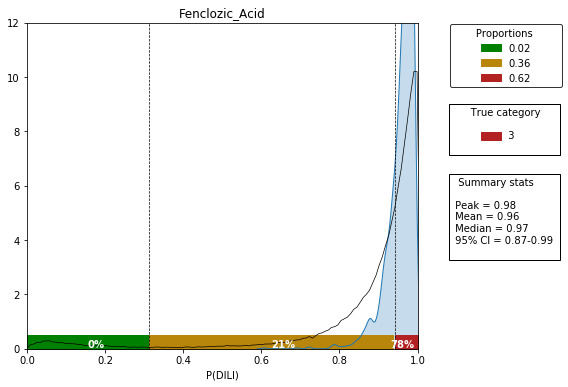

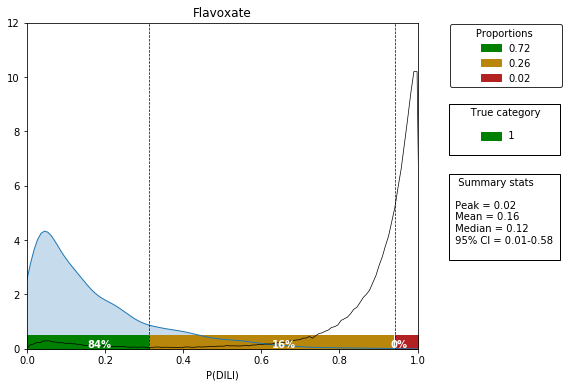

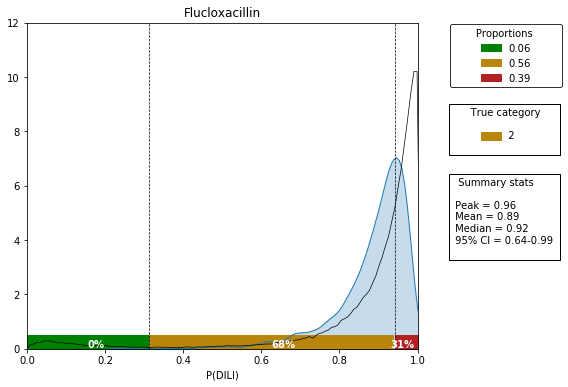

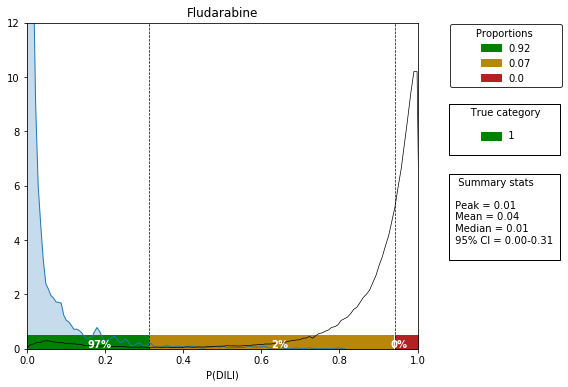

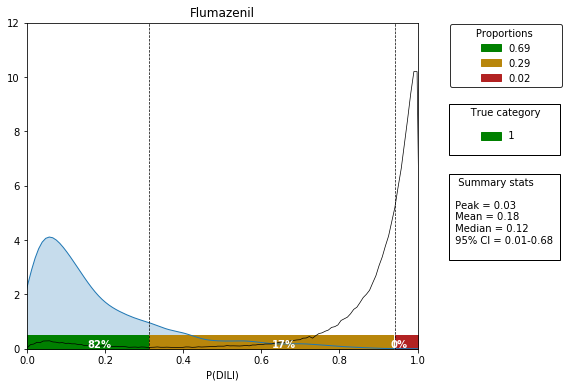

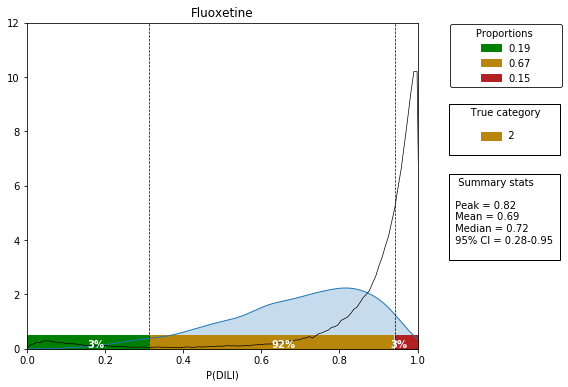

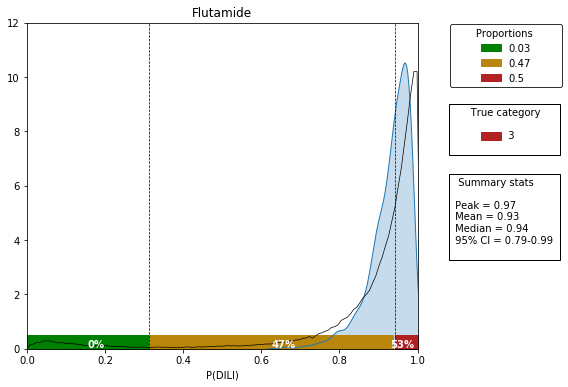

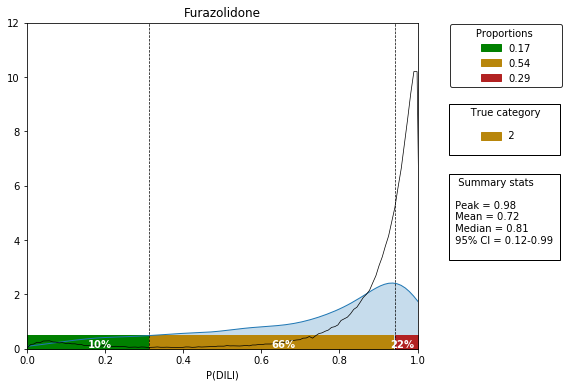

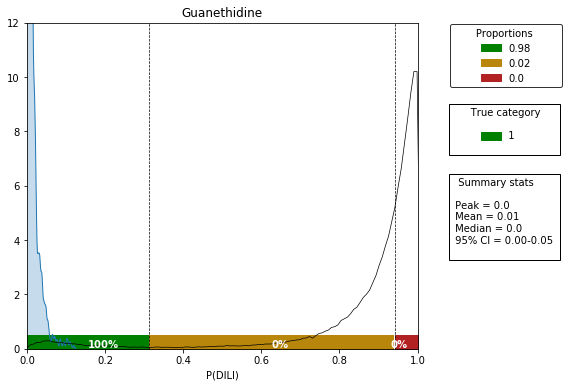

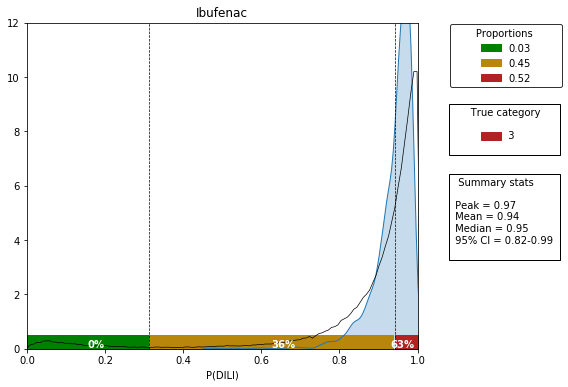

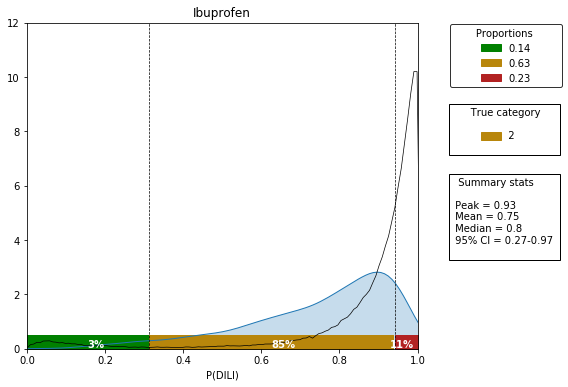

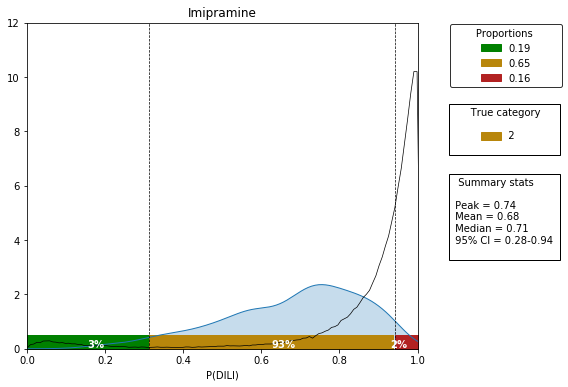

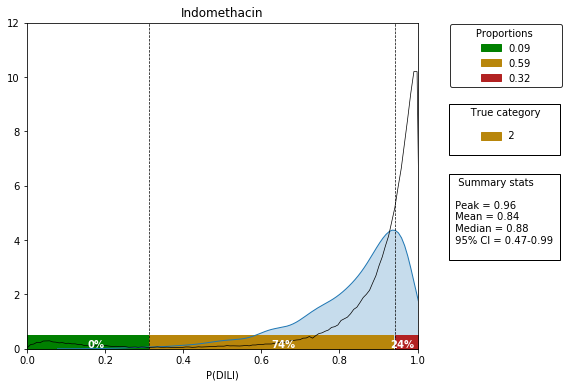

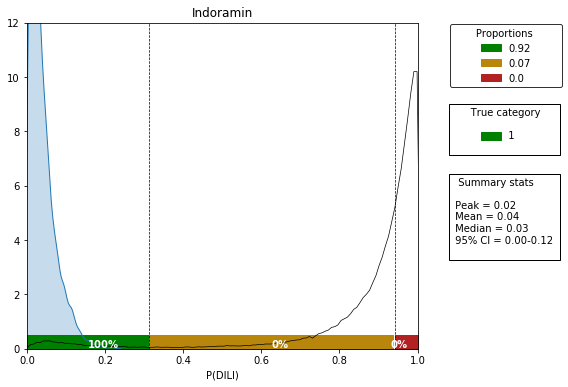

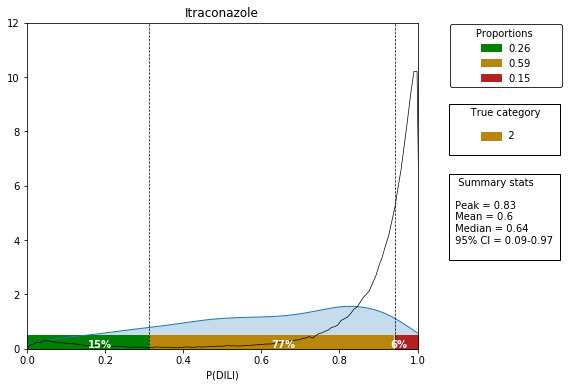

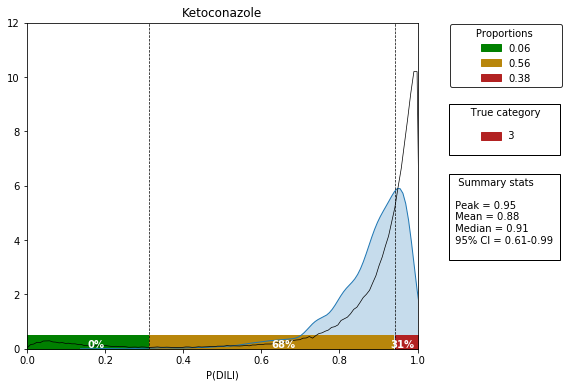

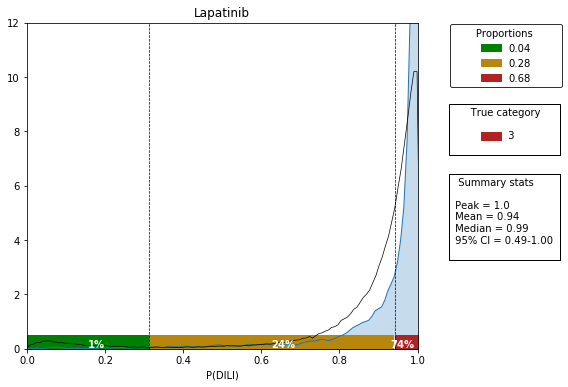

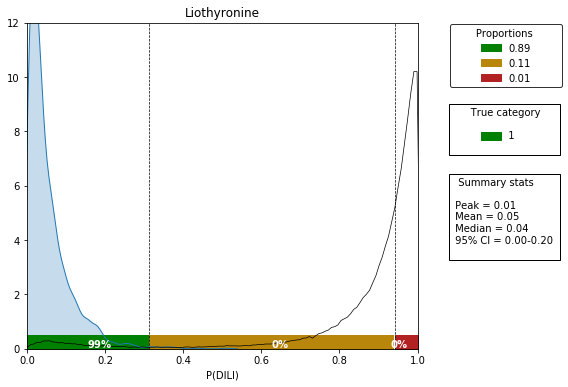

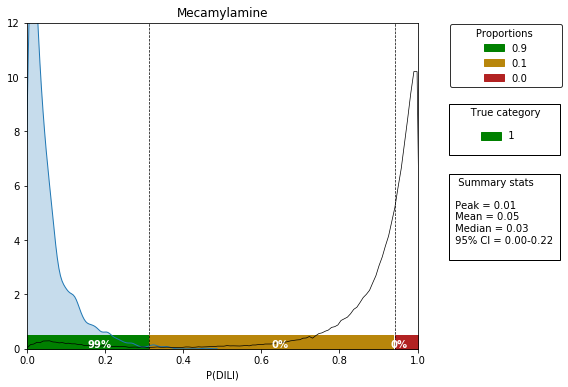

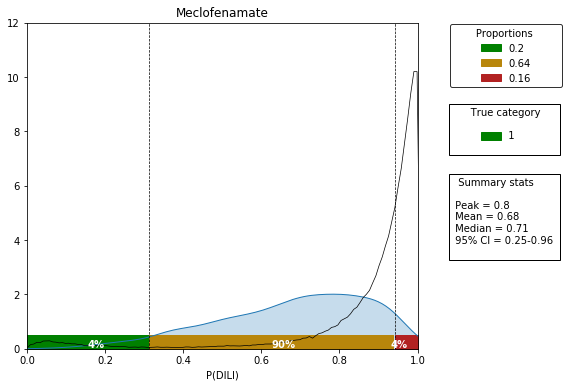

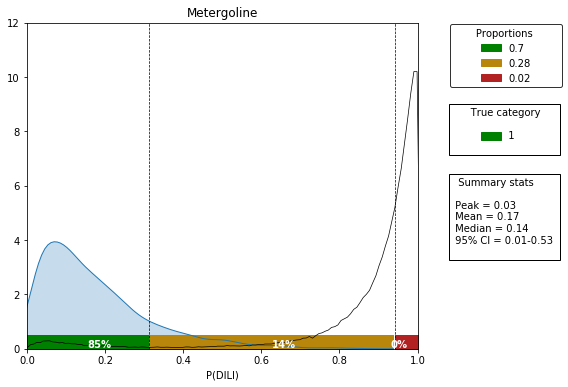

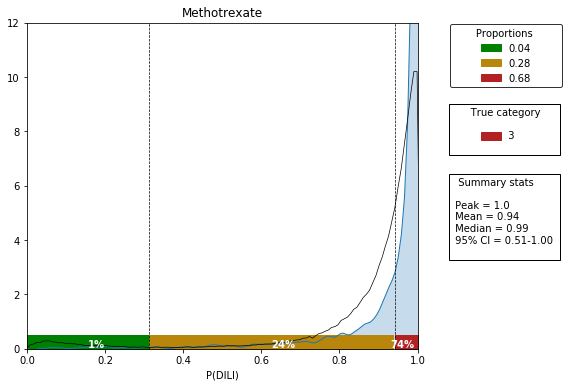

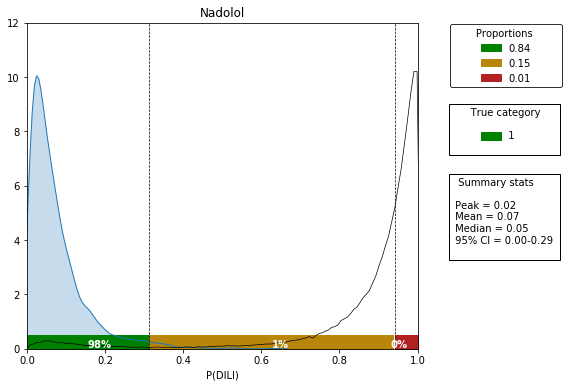

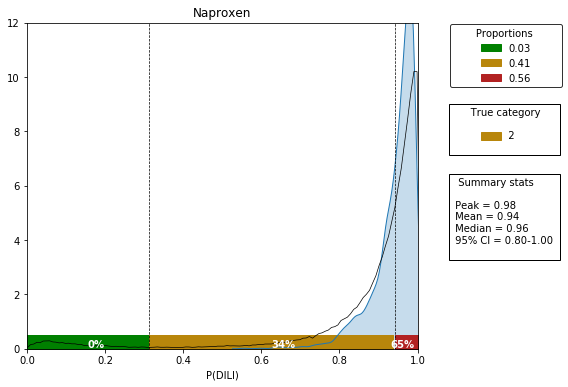

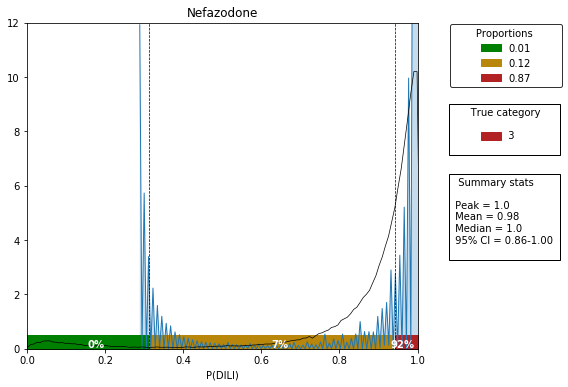

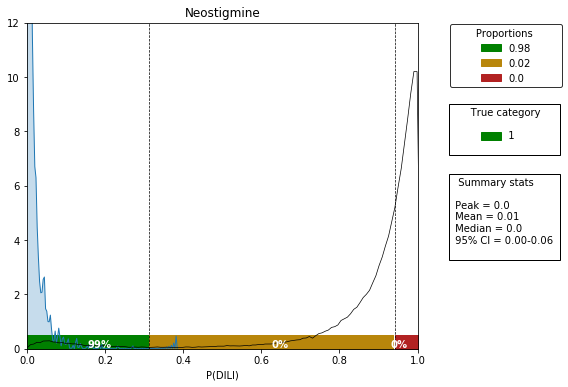

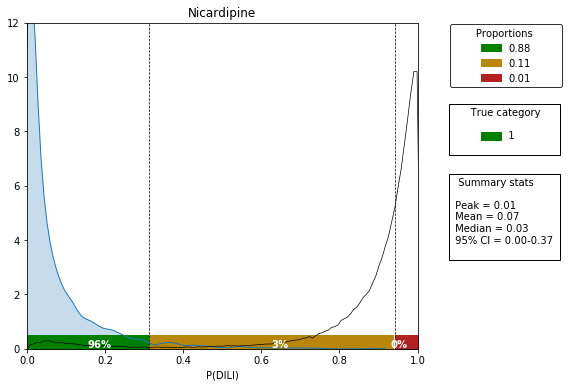

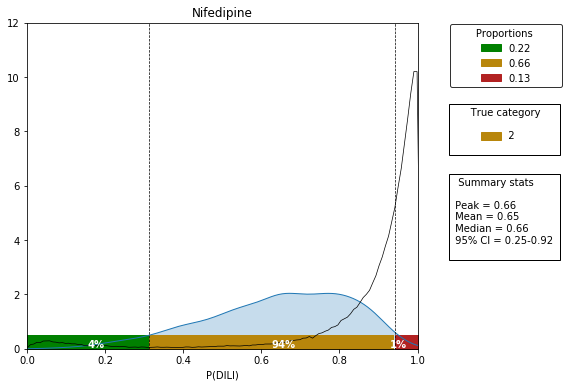

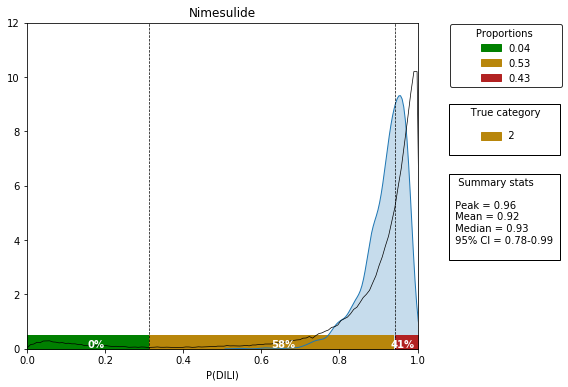

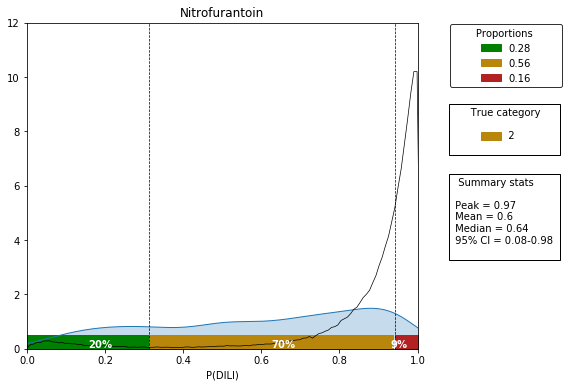

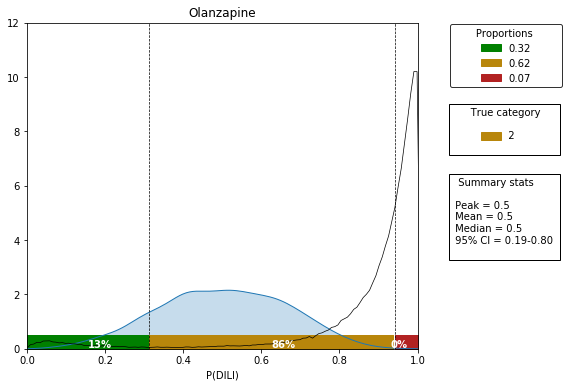

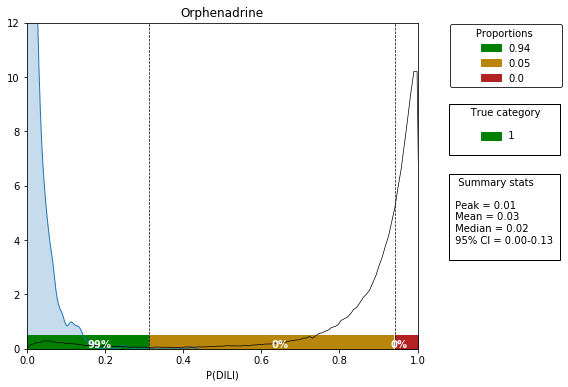

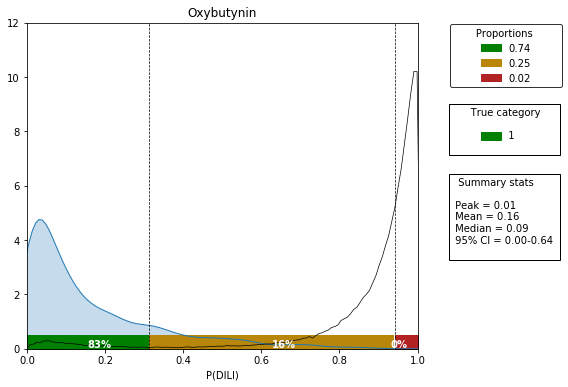

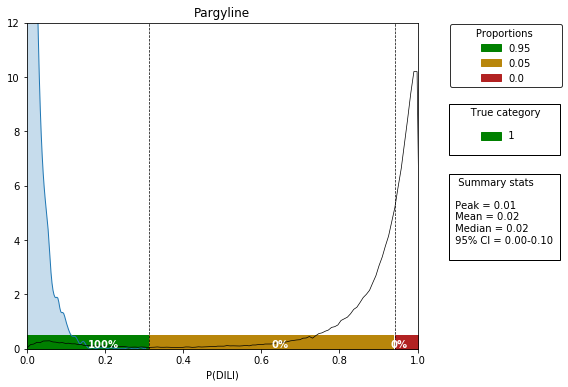

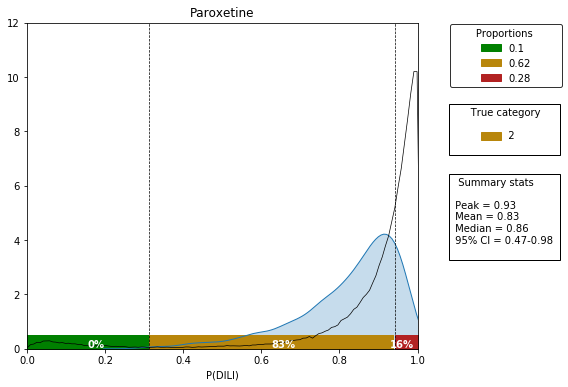

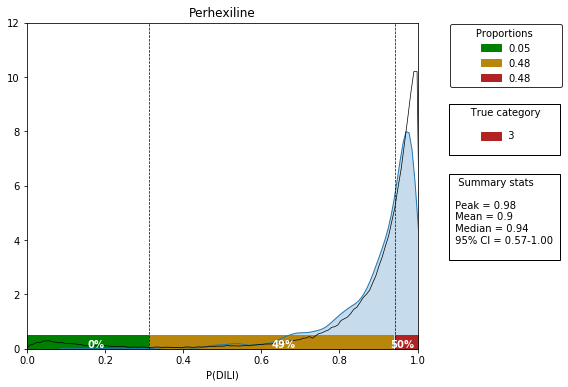

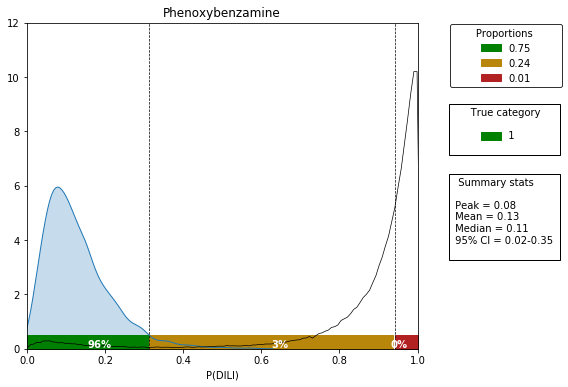

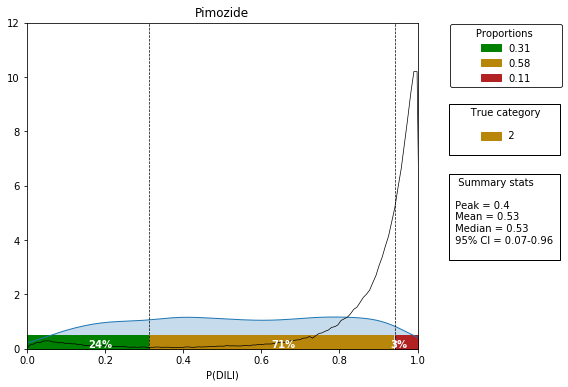

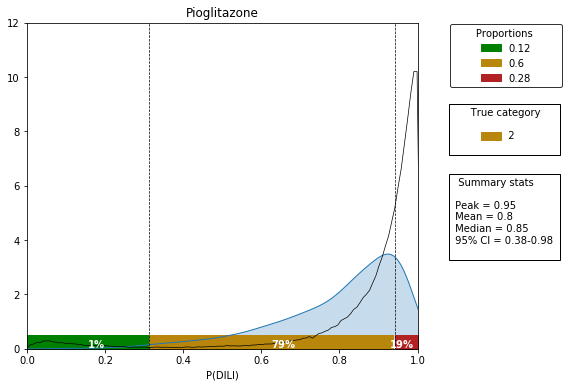

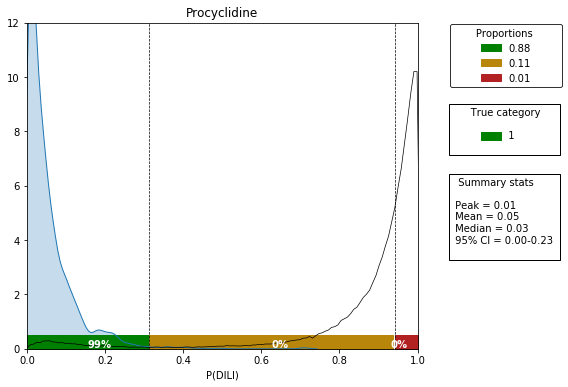

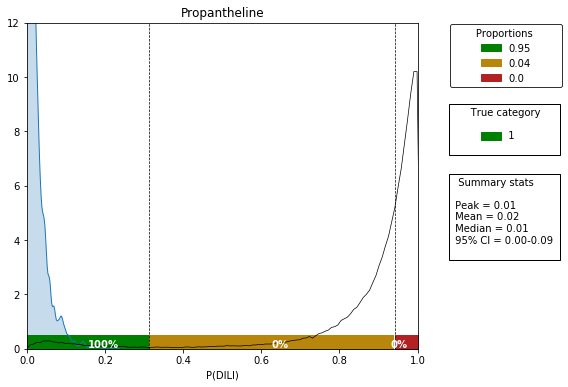

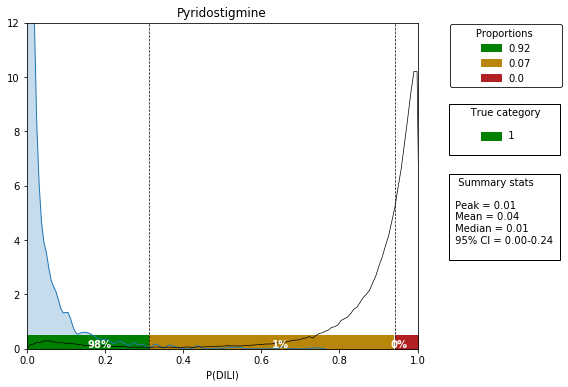

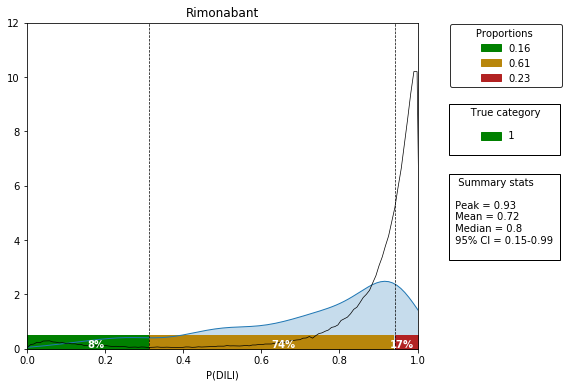

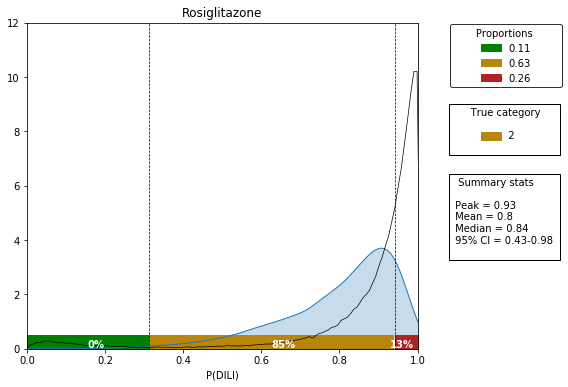

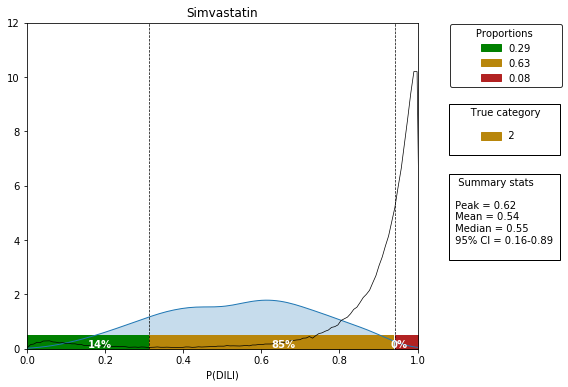

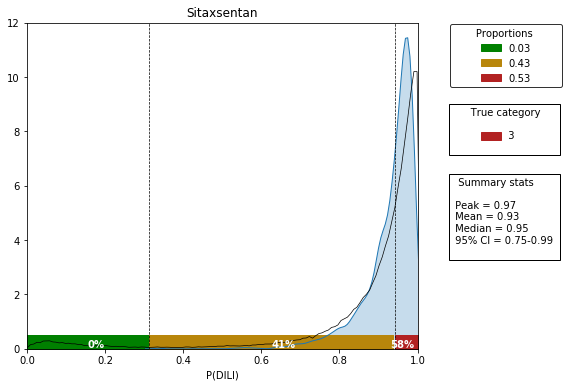

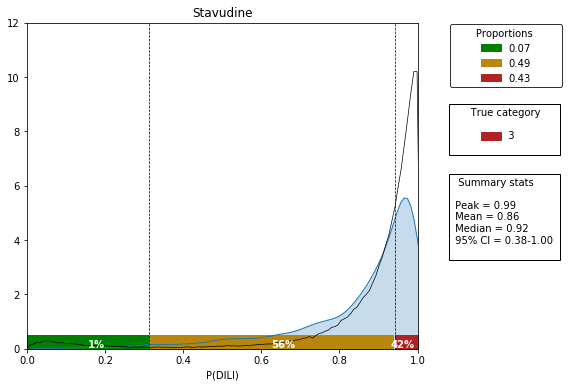

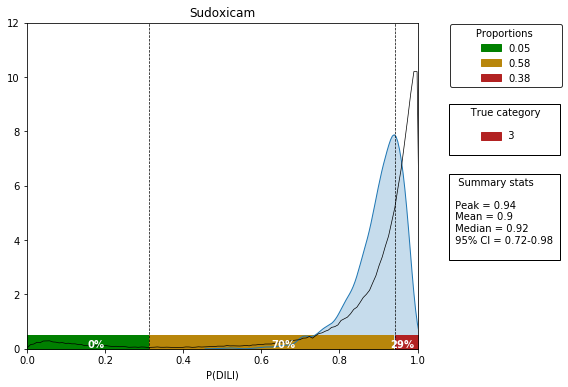

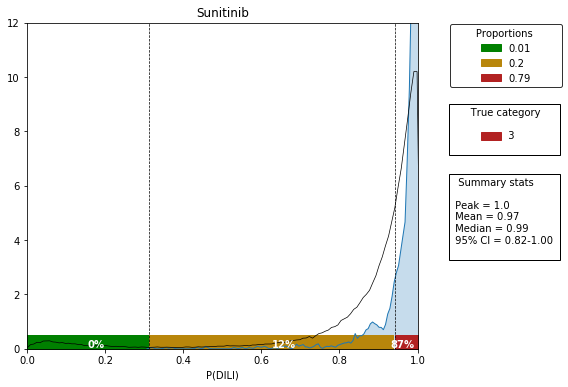

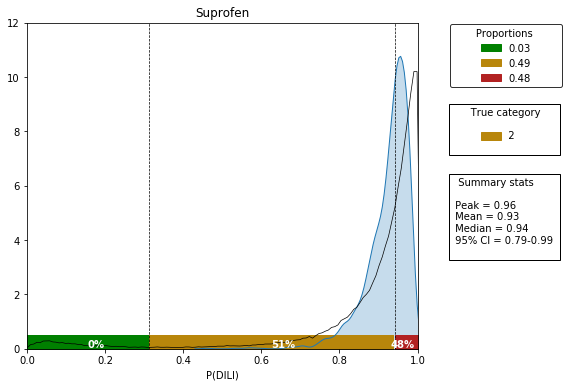

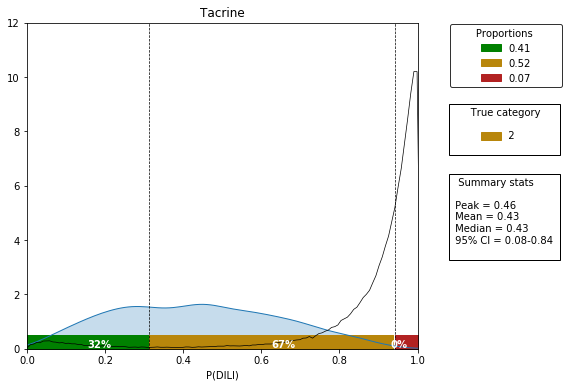

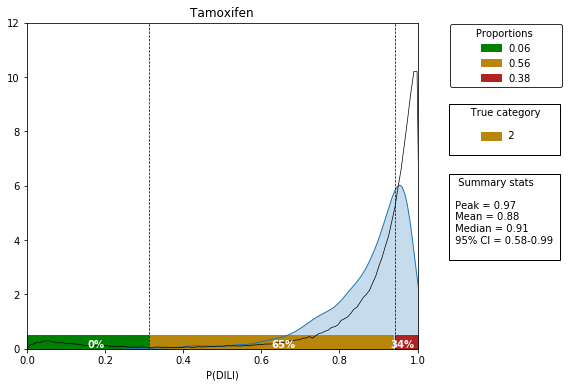

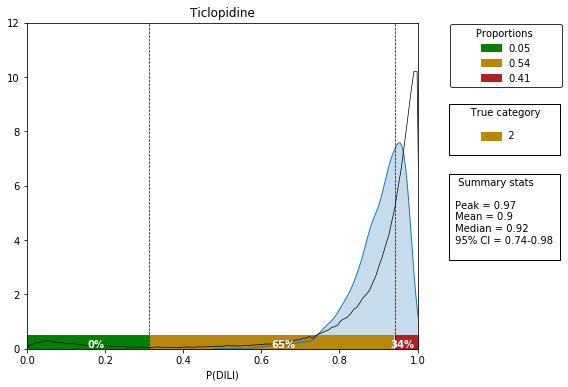

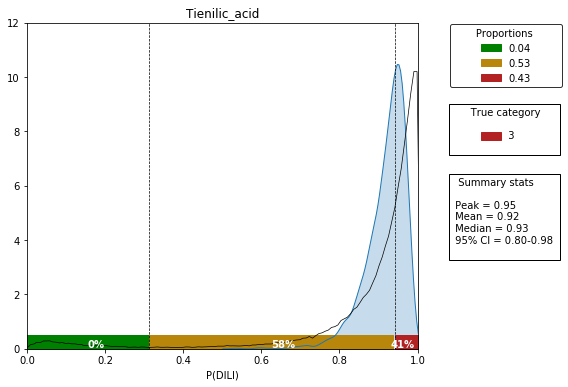

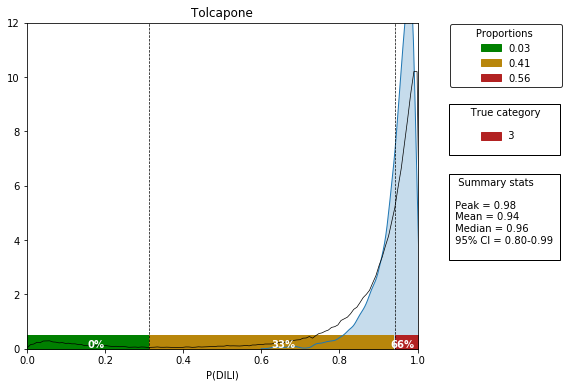

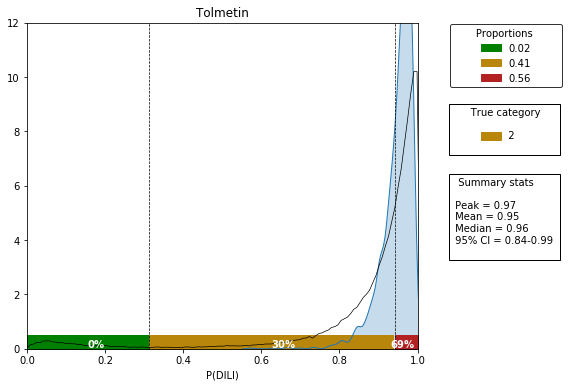

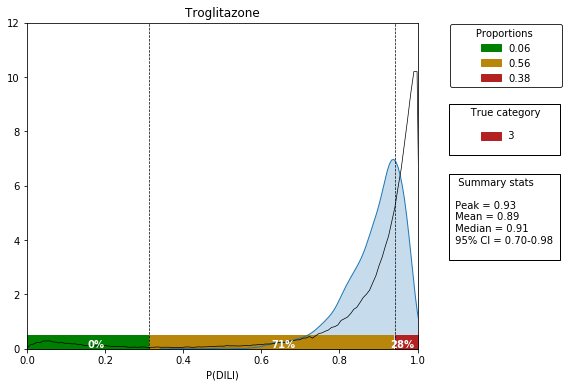

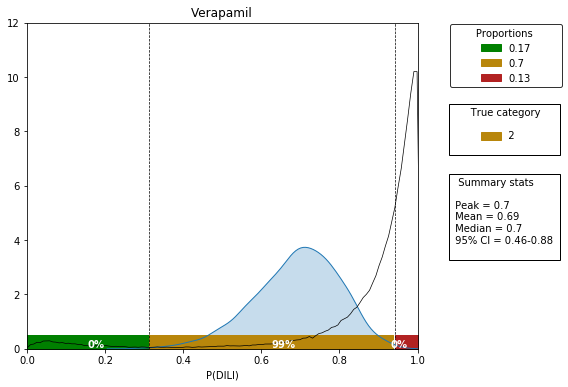

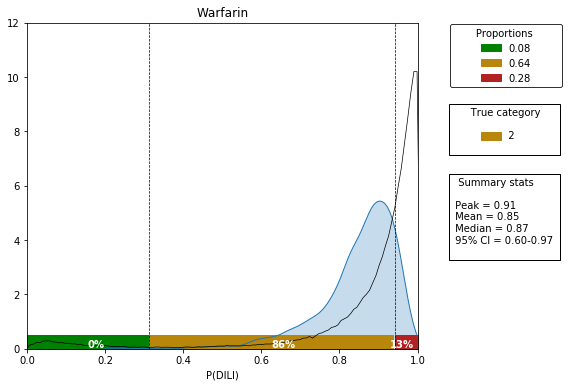

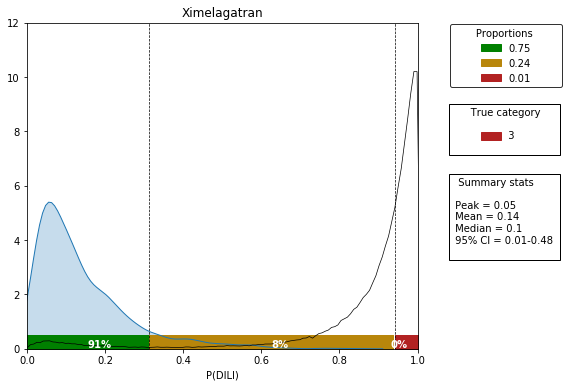

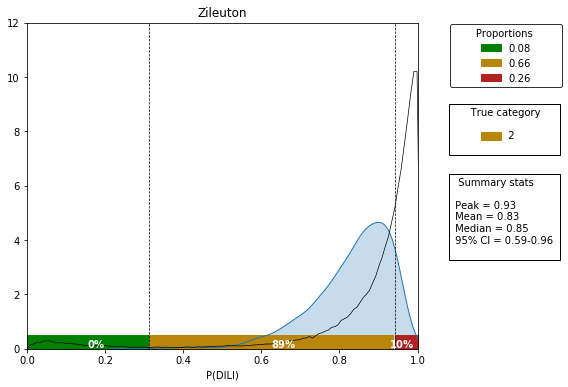

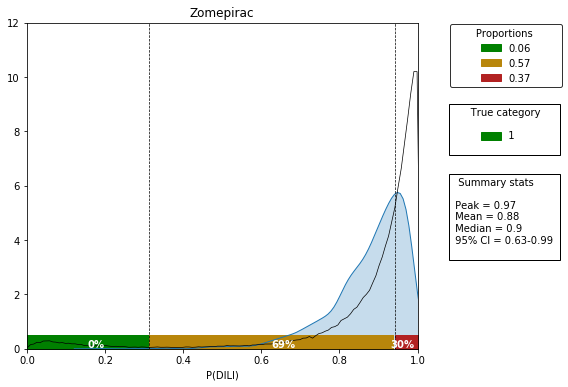

In [37]:
# compute posterior probabilities and plot results

fig, ax = plt.subplots(frameon=False)
ax.axis('off')
plt.close()

# define function to plot posterior density
def postplot(y_pred_df, ind):
    
    post_ind = post[:,ind]
    
    res = summary_stats(post_ind)

    plt.figure(figsize=(7,6))
    sns.distplot(post_ind, hist = False, kde = True,
                         kde_kws = {'shade': True, 'linewidth': 1}, 
                          label = "")

    plt.axvline(c1, 0, 12, color="black", ls = '--', linewidth=0.7)
    plt.axvline(c2, 0, 12, color="black", ls = '--', linewidth=0.7)
    plt.title(drug_names.iloc[ind]['Drug'])
    plt.xlabel('P(DILI)')

    # plot colored bars
    section1 = np.arange(-0.05, c1, c1/200.)
    section2 = np.arange(c1, c2, (c2-c1)/200.)
    section3 = np.arange(c2, 1.05, (1-c2)/200.)
    plt.fill_between(section1, 0.50, color="green")
    plt.fill_between(section2, 0.50, color ="darkgoldenrod" )
    plt.fill_between(section3, 0.50, color="firebrick")
    pers = percs(post, ind)
    pers1 = pers[0]
    pers2 = pers[1]
    pers3 = pers[2]

    plt.text(c1/2, 0.05, str(int(pers1 * 100))+'%', fontsize=10, color="white", fontweight='bold')
    plt.text(c1+(c2-c1)/2, 0.05, str(int(pers2 * 100))+'%', fontsize=10, color="white", fontweight='bold')
    plt.text(1-0.07, 0.05, str(int(pers3 * 100))+'%', fontsize=10, color="white", fontweight='bold')

    # make legend
    proportions = probs(y_pred_train_df, ind)
    p1 = round(proportions[0],2)
    p2 = round(proportions[1],2)
    p3 = round(proportions[2],2)
    green_patch = mpatches.Patch(color='green', label= p1)
    golden_patch = mpatches.Patch(color='darkgoldenrod', label= p2)
    red_patch = mpatches.Patch(color='firebrick', label= p3)
    legend = plt.legend(handles=[green_patch, golden_patch, red_patch],  
                            title="       Proportions        ", 
                            #fontsize='small', 
                            fontsize=10, 
                            loc = "upper left", 
                            frameon=True,
                            bbox_to_anchor=(1.07,1.01))
    legend.get_frame().set_linewidth(1.0)
    legend.get_frame().set_edgecolor('black')
    

    # average profile for DILI category 3 compounds
    plt.plot(av3_x, av3_y, color="black", linewidth=0.7)
    plt.ylim((0,12))
    plt.xlim(0, 1)
    
    
    props1 = dict(boxstyle='square', facecolor='white', alpha=1.0)
        # place a text box in upper left in axes coords
    plt.text(1.19, 1.12, '      True category     \n              \n                  ' 
                 + str(y_train[ind]) + '\n', 
                 transform=ax.transAxes, 
                 fontsize=10,
                 verticalalignment='top', 
                 bbox=props1)

    if y_train[ind]==1:
        true_col = 'g'
    elif y_train[ind]==2:
        true_col = 'darkgoldenrod'
    else:
        true_col = 'firebrick'

    props2 = dict(boxstyle='square', facecolor=true_col, alpha=1.0, edgecolor=true_col)
    plt.text(1.32, 1.0, '  ',transform=ax.transAxes, fontsize=6, verticalalignment='top', bbox=props2)
    plt.text(1.3, 1.0, '  ', transform=ax.transAxes, fontsize=6, verticalalignment='top', bbox=props2)
    plt.text(1.28, 1.0, '  ', transform=ax.transAxes, fontsize=6, verticalalignment='top', bbox=props2)
    
    # place a text box in upper left in axes coords
    
    plt.text(1.19, 0.8, '  Summary stats \n \n' 
                 + ' Peak = ' + str(res[0]) + '\n'
                 + ' Mean = ' + str(res[1]) + '\n'
                 + ' Median = ' + str(res[2]) + '\n'
                 + ' 95% CI = ' + str(res[3]) + "0" * (4 - len(str(res[3]))) + '-' + str(res[4]) + "0" * (4 - len(str(res[4]))) + ' \n', 
                 transform=ax.transAxes, 
                 fontsize=10,
                 verticalalignment='top', 
                 bbox=props1)


    plt.show()

for ind in range(0, len(y_train)):
#for ind in range(3, 4):
    postplot(y_pred_train_df, ind)

### Predict for test data

In [22]:
X_shared.set_value(X_test)
y_shared.set_value([0, 0]) # dummy values
post_pred_test = pm.sample_ppc(trace, samples=5000, model=model)

y_pred_test_df = post_pred_test['y_obs']

# compute posterior probabilities for a selected drug
print(probs(y_pred_test_df, 0))
print(probs(y_pred_test_df, 1))

100%|██████████| 5000/5000 [00:55<00:00, 90.72it/s] 

[0.4618, 0.5044, 0.0338]
[0.5016, 0.4646, 0.0338]
